# Strategy

- S&P 500 (SPY) vs Intermediate-term US Treasuries (IEF)
- Gold (GLD) vs Long-term US Treasuries (TLT)
- US Real Estate (VNQ) vs Intermediate-term US Treasuries (IEF)


![strategy_params](strategy_params.png)


[More info](https://allocatesmartly.com/stokens-active-combined-asset-strategy/)

IEF - 7-10 years bonds

TLT - 20+ bonds


In [1]:
CONFIG = {
  'SPY': {'upper': 126, 'lower': 252, 'defensive_asset': 'IEF'},
  'GLD': {'upper': 252, 'lower': 126, 'defensive_asset': 'TLT'},
  'VNQ': {'upper': 126, 'lower': 252, 'defensive_asset': 'IEF'}
}

In [2]:
import numpy as np

ASSETS = set(np.array([
  [asset, config['defensive_asset']] 
    for (asset, config) in CONFIG.items()
]).flat)

ASSETS

{'GLD', 'IEF', 'SPY', 'TLT', 'VNQ'}

# Load assets history

We will use yahoo finance client to load dividends and prices history for our `ASSETS`.

In [3]:
# pip install --user pandas numpy datetime scipy pandas_datareader yfinance

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from datetime import datetime, date, timedelta

yf.pdr_override()

In [32]:
def load_max_history(assets):
  df = None

  for asset in assets:
    data = yf.Ticker(asset).history(period='max')
    columns = pd.MultiIndex.from_product(
      [data.columns, [asset]],
      names=['property', 'asset']
    )
    multi_level_df = pd.DataFrame(data.values, index=data.index, columns=columns)
    # display(multi_level_df.columns.to_numpy())
    if df is None:
      df = multi_level_df
    else:
      df = df.join(multi_level_df)

  df = df[sorted(df.columns)]
  return df.dropna()

df = load_max_history(ASSETS)[['Close', 'Dividends']]
df.head()

property        Close                                             Dividends  \
asset             GLD        IEF        SPY        TLT        VNQ       GLD   
Date                                                                          
2004-11-18  44.380001  55.061237  84.752510  51.618942  25.282896       0.0   
2004-11-19  44.779999  54.759525  83.810326  51.207062  25.021568       0.0   
2004-11-22  44.950001  54.798054  84.210060  51.473900  25.194227       0.0   
2004-11-23  44.750000  54.746658  84.338547  51.537731  25.301556       0.0   
2004-11-24  45.049999  54.823719  84.538391  51.537731  25.740202       0.0   

property                        
asset       IEF  SPY  TLT  VNQ  
Date                            
2004-11-18  0.0  0.0  0.0  0.0  
2004-11-19  0.0  0.0  0.0  0.0  
2004-11-22  0.0  0.0  0.0  0.0  
2004-11-23  0.0  0.0  0.0  0.0  
2004-11-24  0.0  0.0  0.0  0.0

Create upper and lower channels for risk-on assets defined in the `CONFIG`.

In [ ]:
from operator import itemgetter

In [33]:
for (risk_asset, config) in CONFIG.items():
  (upper_channel_window, lower_channel_window) = itemgetter('upper', 'lower')(config)
  close_prices = df.Close[risk_asset]

  df['Upper_Channel', risk_asset] = close_prices\
    .rolling(window=upper_channel_window).max().shift(1)
  df['Lower_Channel', risk_asset] = close_prices\
    .rolling(window=lower_channel_window).min().shift(1)

df = df[sorted(df.columns)]

In [35]:
df.iloc[250:].head() # deliberate shift to check the first moment where 252 lower/upper channel appeared for the first time

property        Close                                             Dividends  \
asset             GLD        IEF        SPY        TLT        VNQ       GLD   
Date                                                                          
2005-11-15  46.660000  55.254726  89.464447  54.242771  29.501310       0.0   
2005-11-16  47.779999  55.534737  89.645943  54.813034  29.333395       0.0   
2005-11-17  48.480000  55.641392  90.480766  54.946541  29.817362       0.0   
2005-11-18  48.459999  55.508087  90.836479  54.691681  29.925987       0.0   
2005-11-21  48.990002  55.614761  91.293808  54.855503  30.074144       0.0   

property                       Lower_Channel                        \
asset       IEF  SPY  TLT  VNQ           GLD        SPY        VNQ   
Date                                                                 
2005-11-15  0.0  0.0  0.0  0.0     41.529999        NaN        NaN   
2005-11-16  0.0  0.0  0.0  0.0     41.529999        NaN        NaN   
2005-11-17  0.0  0.0  0.0  0.0     41.529999  81.930779  24.664749   
2005-11-18  0.0  0.0  0.0  0.0     41.529999  81.930779  24.664749   
2005-11-21  0.0  0.0  0.0  0.0     41.529999  81.930779  24.664749   

property   Upper_Channel                        
asset                GLD        SPY        VNQ  
Date                                            
2005-11-15           NaN  90.155075  30.903227  
2005-11-16           NaN  90.155075  30.903227  
2005-11-17     47.779999  90.155075  30.903227  
2005-11-18     48.480000  90.480766  30.903227  
2005-11-21     48.480000  90.836479  30.903227

In [34]:
df.iloc[124:].head() # deliberate shift to check the first moment where 126 lower/upper channel appeared for the first time

property        Close                                             Dividends  \
asset             GLD        IEF        SPY        TLT        VNQ       GLD   
Date                                                                          
2005-05-18  42.049999  56.360676  85.523315  55.499554  27.330286       0.0   
2005-05-19  41.980000  56.190639  85.883324  55.357185  27.692450       0.0   
2005-05-20  41.650002  56.184097  85.760918  55.422451  27.750385       0.0   
2005-05-23  41.619999  56.439182  86.236076  55.855408  27.813171       0.0   
2005-05-24  41.730000  56.589592  86.034500  56.009659  27.426867       0.0   

property                       Lower_Channel         Upper_Channel             \
asset       IEF  SPY  TLT  VNQ           GLD SPY VNQ           GLD        SPY   
Date                                                                            
2005-05-18  0.0  0.0  0.0  0.0           NaN NaN NaN           NaN        NaN   
2005-05-19  0.0  0.0  0.0  0.0           NaN NaN NaN           NaN        NaN   
2005-05-20  0.0  0.0  0.0  0.0     41.259998 NaN NaN           NaN  88.057304   
2005-05-23  0.0  0.0  0.0  0.0     41.259998 NaN NaN           NaN  88.057304   
2005-05-24  0.0  0.0  0.0  0.0     41.259998 NaN NaN           NaN  88.057304   

property               
asset             VNQ  
Date                   
2005-05-18        NaN  
2005-05-19        NaN  
2005-05-20  27.692450  
2005-05-23  27.750385  
2005-05-24  27.813171

In [50]:
last_day = df.iloc[-1]

lower = []
upper = []
current = []
index = []
for (risk_asset, config) in CONFIG.items():
  index.append(risk_asset)
  lower.append(last_day.Lower_Channel[risk_asset])
  current.append(last_day.Close[risk_asset])
  upper.append(last_day.Upper_Channel[risk_asset])

pd.options.display.float_format = '${:,.2f}'.format
display(pd.DataFrame({'lower': lower, 'current': current, 'upper': upper}, index=index))
pd.options.display.float_format = None

,lower,current,upper
SPY,$365.20,$437.98,$477.71
GLD,$161.32,$171.09,$178.77
VNQ,$82.58,$105.23,$116.01


In [24]:
from dotmap import DotMap

In [51]:
SLIPPAGE = 0.01
FEE = 0.02
TAX = 0.15 # we pay 15% tax on dividends here (but it can vary a lot depending on circumstances)

cash = 50000 # initial cash
portfolio = []

def flatten_portfolio(portfolio): 
  dict = {}
  for item in portfolio:
    dict[item['asset']] = item['amount']
  return dict

results = DotMap(portfolio_value=[], cash=[], portfolio=[])

for x in range(0, df.shape[0]):

  today = df.iloc[x]
  close_price = today.Close
  dividends = today.Dividends

  # initialize portfolio - start with risk on
  if len(portfolio) == 0:
    portfolio = [{}] * len(CONFIG)
    fraction = cash / len(CONFIG)

    for (index, (asset, config)) in enumerate(CONFIG.items()):
      ask_price = close_price[asset] + SLIPPAGE
      amount = np.floor(fraction / ask_price)
      cash -= amount * ask_price
      cash -= amount * FEE
      portfolio[index] = {'asset': asset, 'amount': amount}

    portfolio_value = cash
    for item in portfolio:
      portfolio_value += close_price[item['asset']] * item['amount']

    results.portfolio_value.append(portfolio_value)
    results.cash.append(cash)
    results.portfolio.append(flatten_portfolio(portfolio))

    continue

  # add dividends
  for item in portfolio:
    (asset, amount) = itemgetter('asset', 'amount')(item)
    maybe_divs = dividends[asset]
    if not np.isnan(maybe_divs):
      cash += (amount * maybe_divs) * (1 - TAX) 
    # TODO rebalance if necessary

  # calculate portfolio value
  portfolio_value = cash
  for item in portfolio:
    (asset, amount) = itemgetter('asset', 'amount')(item)
    portfolio_value += (close_price[asset] - SLIPPAGE) * amount

  # check if need to replace some assets with defensive assets
  upper_channel = today.Upper_Channel
  lower_channel = today.Lower_Channel

  new_assets = [None] * len(CONFIG)
  for (index, (risk_asset, config)) in enumerate(CONFIG.items()):
    my_asset = portfolio[index]['asset']
    defensive_asset = config['defensive_asset']

    if close_price[risk_asset] > upper_channel[risk_asset] and my_asset != risk_asset:
      new_assets[index] = risk_asset
    elif close_price[risk_asset] < lower_channel[risk_asset] and my_asset != defensive_asset:
      new_assets[index] = defensive_asset

  needs_rotation = not all(asset is None for asset in new_assets)
  if needs_rotation:
    fraction = portfolio_value / 3
    for (index, item) in enumerate(portfolio):
      # do we need to replace item completely?
      # if not new_assets[index] is None and item['asset'] != new_assets[index]:
      if not new_assets[index] is None:
        # sell current asset
        cash += item['amount'] * (close_price[item['asset']] - SLIPPAGE)
        cash -= amount * FEE
        # buy new asset

        # TODO may be unified with initialization
        asset = new_assets[index]
        ask_price = close_price[asset] + SLIPPAGE
        amount = np.floor(fraction / ask_price)
        cash -= amount * ask_price
        cash -= amount * FEE
        # save new asset in the portfolio
        item['asset'] = asset 
        item['amount'] = amount

      # do we need to rebalance?
      else:
        asset = item['asset']
        price = close_price[asset]
        new_amount = np.floor(fraction / price)
        diff = item['amount'] - new_amount
        if diff != 0:
          # rebalance
          if diff > 0: # => item['amount'] > new_amount => sell
            cash += diff * (price - SLIPPAGE)
          else: # => item['amount'] < new_amount => buy
            cash += diff * (price + SLIPPAGE)

          cash -= abs(diff) * FEE
          item['amount'] = new_amount

    # calculate updated portfolio value
    portfolio_value = cash
    for item in portfolio:
      portfolio_value += close_price[item['asset']] * item['amount']

  results.portfolio_value.append(portfolio_value)
  results.cash.append(cash)
  results.portfolio.append(flatten_portfolio(portfolio))

result_df = pd.DataFrame(results, index=df.index)

# dumping results dataframe to HTML can be good for debug purposes
#
# with open('out.html', 'w') as file:
#   file.write(df.join(result_df).to_html())

result_df.head()

,portfolio_value,cash,portfolio
Date,,,
2004-11-18,49963.130000,72.99203,"{'SPY': 196.0, 'GLD': 375.0, 'VNQ': 658.0}"
2004-11-19,49744.217335,72.99203,"{'SPY': 196.0, 'GLD': 375.0, 'VNQ': 658.0}"
2004-11-22,49999.925609,72.99203,"{'SPY': 196.0, 'GLD': 375.0, 'VNQ': 658.0}"
2004-11-23,50020.730800,72.99203,"{'SPY': 196.0, 'GLD': 375.0, 'VNQ': 658.0}"
2004-11-24,50461.029285,72.99203,"{'SPY': 196.0, 'GLD': 375.0, 'VNQ': 658.0}"


In [52]:
result_df.tail()

,portfolio_value,cash,portfolio
Date,,,
2022-01-14,400649.860085,6499.533266,"{'SPY': 294.0, 'TLT': 794.0, 'VNQ': 1322.0}"
2022-01-18,395121.934838,6499.533266,"{'SPY': 294.0, 'TLT': 794.0, 'VNQ': 1322.0}"
2022-01-19,392568.439889,6499.533266,"{'SPY': 294.0, 'TLT': 794.0, 'VNQ': 1322.0}"
2022-01-20,389978.072381,6499.533266,"{'SPY': 294.0, 'TLT': 794.0, 'VNQ': 1322.0}"
2022-01-21,388397.844811,6499.533266,"{'SPY': 294.0, 'TLT': 794.0, 'VNQ': 1322.0}"


# Total annualized returns

In [53]:
first = result_df.iloc[0]
last = result_df.iloc[-1]

years = (last.name - first.name).days / 365.25

annualized_return = (last['portfolio_value']  / first['portfolio_value']) ** (1/years) - 1

print(
  """Annualized return is: %.2f%%
over the period of %.2f years
from %s to %s""" % (
    100 * annualized_return,
    years,
    date.fromtimestamp(first.name.timestamp()), 
    date.fromtimestamp(last.name.timestamp())
  )
)


Annualized return is: 12.68%
over the period of 17.17 years
from 2004-11-18 to 2022-01-21


# Overall performance

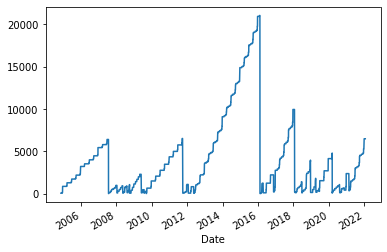

In [61]:
result_df.cash.plot()

Initial investment at 2004-11-18: 10000
Last value at 2022-01-21: 77736.89


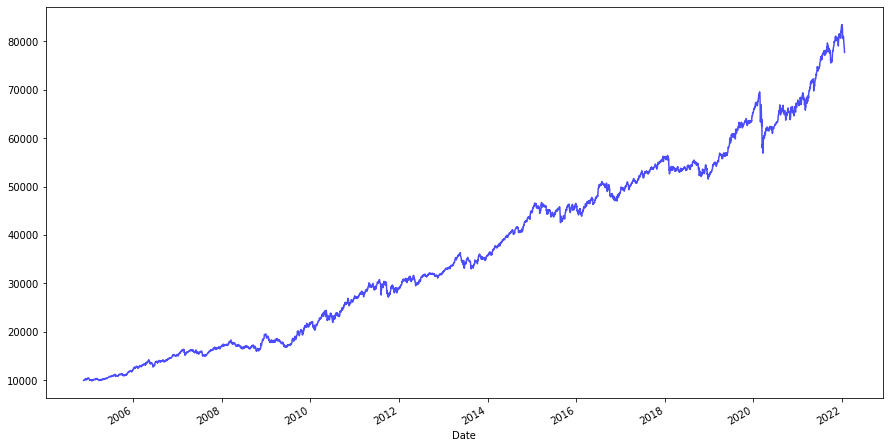

In [54]:
log_returns = np.log(result_df.portfolio_value).diff()

cum_returns = log_returns.cumsum() 

CAPITAL = 10000

perf = CAPITAL * np.exp(cum_returns)
plt.figure()
perf.plot(figsize=(15,8), color='b', alpha=0.7)

print(f'Initial investment at {perf.index[0].date()}: {CAPITAL}')
print(f'Last value at {perf.index[-1].date()}: {perf[-1]:.2f}')

In [55]:
TRADING_DAYS_YEARLY = 252
# RISK_FREE_RATE = 0.02
RISK_FREE_RATE = 0.00

annual_return = np.exp(log_returns.mean() * TRADING_DAYS_YEARLY) - 1
annual_volatility = log_returns.std() * np.sqrt(TRADING_DAYS_YEARLY)

sharpe_ratio = (annual_return - RISK_FREE_RATE) / annual_volatility

annualized_downside = log_returns.loc[log_returns<0].std() * np.sqrt(TRADING_DAYS_YEARLY)
sortino_ratio = (annual_return - RISK_FREE_RATE) / annualized_downside  

sortino_ratio = (annual_return - RISK_FREE_RATE) / annualized_downside  

print(
  f"""Annulaized return {(annual_return * 100):.2f}%
Annualized volatility {(annual_volatility * 100):.2f}%
Sharpe ratio {sharpe_ratio:.2f}
Sortino ratio {sortino_ratio:.2f}
""" 
)

Annulaized return 12.70%
Annualized volatility 10.91%
Sharpe ratio 1.16
Sortino ratio 1.55



# Returns by month/by year

In [56]:

def montly_results(result_df):
  initial_value = result_df['portfolio_value'][0]

  grouping = pd.MultiIndex.from_tuples(
    zip(result_df.index.year, result_df.index.month),
    names=['year', 'month']
  )

  by_month = result_df.groupby(by=grouping).last()[['portfolio_value']]
  by_month = by_month.join(by_month.shift(1).add_prefix('prev_')).fillna(initial_value)

  table = pd.DataFrame(
    {
      'change': 100 * (by_month['portfolio_value'] / by_month['prev_portfolio_value'] - 1),
    },
    index = grouping
  ).dropna().reset_index()

  montly_results = table.pivot_table(index=['year'], columns=['month'], values=['change'])

  grouping = result_df.index.year
  by_year = result_df.groupby(by=grouping).last()[['portfolio_value']]
  by_year = by_year.join(by_year.shift(1).add_prefix('prev_')).fillna(initial_value)

  montly_results['total'] = 100 * (by_year['portfolio_value'] / by_year['prev_portfolio_value'] - 1)

  return montly_results

pd.options.display.float_format = lambda x: 'N/A' if np.isnan(x) else '{:,.2f}%'.format(x)
display(montly_results(result_df))
pd.options.display.float_format = None 


change                                                                 \
month      1      2      3      4      5      6      7      8      9     10   
year                                                                          
2004     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2005  -4.79%  2.73% -0.87%  1.66%  0.98%  3.80%  3.27% -1.38%  3.84% -1.92%   
2006   6.38%  0.41%  3.73%  3.12% -2.16%  0.68%  2.48%  1.28%  0.57%  3.37%   
2007   4.28% -0.73% -0.35%  1.76%  0.06% -3.34% -3.25%  1.70%  5.14%  3.35%   
2008   2.19%  2.85% -1.02% -2.73% -1.30% -0.82%  0.77% -1.22%  1.30% -5.36%   
2009  -7.10% -0.67%  3.80% -3.76% -2.21% -0.69%  2.67%  6.85%  4.29% -0.93%   
2010  -3.45%  3.95%  5.77%  4.84% -3.42% -1.98%  3.44%  0.05%  6.34%  3.99%   
2011  -0.31%  4.59%  0.38%  5.73% -0.43% -1.94%  2.70%  0.73% -9.02%  5.52%   
2012   5.25%  0.04%  2.88%  0.69% -4.33%  3.12%  2.40%  0.45% -0.02% -1.00%   
2013   1.95%  1.29%  2.69%  4.33% -3.12% -1.44%  1.62% -3.69%  3.10%  3.63%   
2014   1.41%  3.51%  1.13%  1.88%  2.44%  1.67% -0.26%  3.69% -2.41%  4.68%   
2015   3.53% -0.84%  0.67% -2.33% -0.16% -2.63%  3.74% -4.32%  1.06%  4.71%   
2016  -1.54% -0.79%  3.87%  0.55% -0.85%  5.88%  3.27% -2.34%  0.01% -3.44%   
2017   0.78%  3.06% -0.55%  0.97%  0.89%  1.74%  0.95%  1.13%  0.46%  0.51%   
2018  -0.61% -4.12% -0.18% -0.52%  0.81% -0.16%  1.02%  2.44% -0.96% -4.23%   
2019   4.21% -0.25%  4.49% -0.25%  0.22%  5.06%  1.05%  3.35%  0.41%  1.96%   
2020   1.89% -5.02% -5.28%  2.63%  1.16%  1.03%  4.41%  1.03% -2.40% -1.47%   
2021  -1.39%  0.35%  1.78%  5.33%  0.55%  3.39%  3.54%  1.68% -4.16%  5.63%   
2022  -6.89%    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                     total  
month     11     12         
year                        
2004   0.92%  3.20%  4.15%  
2005   4.58%  3.30% 15.77%  
2006   4.38%  0.38% 27.26%  
2007  -0.46%  2.48% 10.74%  
2008  10.34%  8.85% 13.54%  
2009   8.51%  1.23% 11.45%  
2010   0.05%  5.00% 26.66%  
2011  -0.64% -0.52%  6.05%  
2012   0.48%  1.56% 11.79%  
2013  -1.16%  1.52% 10.85%  
2014   2.46%  2.11% 24.52%  
2015  -0.22%  0.63%  3.49%  
2016  -1.35%  3.23%  6.23%  
2017   2.20%  1.68% 14.67%  
2018   2.82% -3.05% -6.81%  
2019  -0.36%  2.90% 25.05%  
2020   1.22%  5.04%  3.70%  
2021  -0.18%  4.81% 22.99%  
2022     NaN    NaN -6.89%

# Drawdown analysis

Text(0, 0.5, 'Drawdown, %')

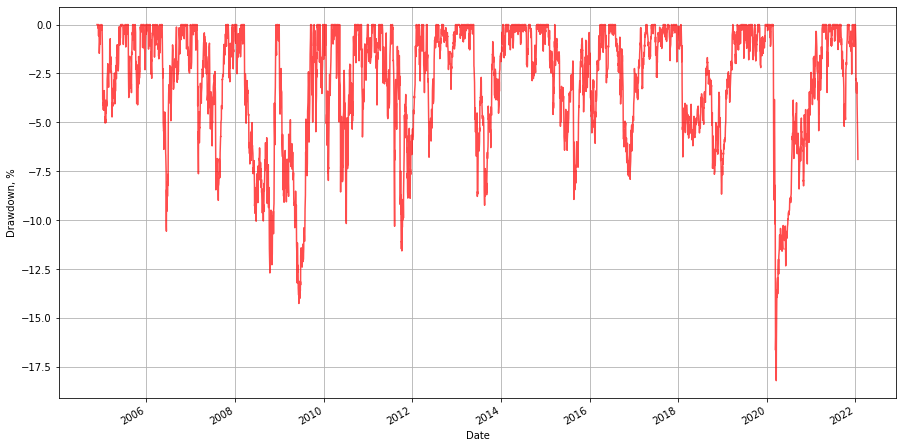

In [57]:
last_peak = cum_returns.cummax()

log_dd = cum_returns - last_peak

pct_dd = (np.exp(log_dd) - 1) * 100

ax = pct_dd.plot(figsize=(15,8), color='r', alpha=0.7)
ax.grid(axis='both')
ax.set_ylabel('Drawdown, %')

# plt.savefig('drawdown_evaluation.svg')


## Longest/max drawdowns

In [58]:

def find_true_streaks(array):
  # finds all "True" streaks in array from longest to shortest

  masked = np.concatenate(([False], array, [False]))       
  true_streaks = np.flatnonzero(masked[1:] != masked[:-1]).reshape(-1, 2) 
  ends = true_streaks[:,1]
  true_streaks_descending = (true_streaks[:,1] - true_streaks[:,0]).argsort()[::-1]
  return true_streaks[true_streaks_descending]

dd_streaks = find_true_streaks(pct_dd.values != 0)

def print_streak(n):
  start, end = dd_streaks[n]
  days = (pct_dd.index[end] - pct_dd.index[start]).days
  years = days / 365.25
  months = years * 12

  print(
    f"""#{n + 1}: Drawdown: {days} days = {months:.2f} months = {years:.2f} years
From {pct_dd.index[start].date()} to {pct_dd.index[end].date()}""" 
  )

print("Longest drawdowns")
for i in range(5):
  if dd_streaks.size <= i: break
  print_streak(i)

if dd_streaks.size == 0:
  print("No drawdown found")

print()
max_dd_index = np.argmin(pct_dd)
print(f"""Max drawdown {pct_dd.iloc[max_dd_index]:.2f}% on {pct_dd.index[max_dd_index].date()}""")

Longest drawdowns
#1: Drawdown: 427 days = 14.03 months = 1.17 years
From 2018-01-24 to 2019-03-27
#2: Drawdown: 406 days = 13.34 months = 1.11 years
From 2020-02-24 to 2021-04-05
#3: Drawdown: 372 days = 12.22 months = 1.02 years
From 2015-03-23 to 2016-03-29
#4: Drawdown: 261 days = 8.57 months = 0.71 years
From 2008-03-18 to 2008-12-04
#5: Drawdown: 258 days = 8.48 months = 0.71 years
From 2008-12-31 to 2009-09-15

Max drawdown -18.20% on 2020-03-19


## Drawdown quantiles

Quantiles:
50.0% of time expected drawdown is no more than 2.34% theoretically or 2.50% actually
75.0% of time expected drawdown is no more than 4.69% theoretically or 5.15% actually
95.0% of time expected drawdown is no more than 10.13% theoretically or 9.47% actually
99.0% of time expected drawdown is no more than 15.57% theoretically or 12.42% actually
Max DD was 18.20%
Last DD (2022-01-21) was 6.89%


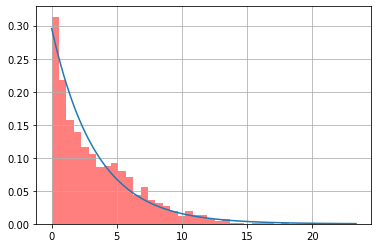

In [59]:
from scipy.stats import expon

nonzero_dd_days = -pct_dd[pct_dd < 0].sort_values()
size = nonzero_dd_days.size

nonzero_dd_days.hist(bins=32, alpha=0.5, density=True, color='red')

params = expon.fit(nonzero_dd_days)

def quantile(p):
  return expon.ppf(p, *params)

xs = np.linspace(quantile(0.001), quantile(0.999), 100)
plt.plot(xs, expon.pdf(xs, *params))

def print_quantile(p):
  theoretical = quantile(p)
  real = nonzero_dd_days[int(size * (1 - p))]
  print(f'{p * 100}% of time expected drawdown is no more than {theoretical:.2f}% theoretically or {real:.2f}% actually')

print('Quantiles:')
for p in [0.50, 0.75, 0.95, 0.99]:
  print_quantile(p)

print(f'Max DD was {nonzero_dd_days[0]:.2f}%')
print(f'Last DD ({pct_dd.index[-1].date()}) was {-pct_dd[-1]:.2f}%')